In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!unzip /content/drive/MyDrive/DL_Project/CornOrMaize.zip -d /content/

In [3]:
#pip install matplotlib

In [4]:
#dataset taken from https://www.kaggle.com/smaranjitghose/corn-or-maize-leaf-disease-dataset

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=212,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 4188 files belonging to 4 classes.


In [8]:
class_names=dataset.class_names
n_class=len(dataset.class_names)
print(n_class)

4


In [9]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [10]:
print(len(dataset))

131


In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[3 0 0 3 1 3 3 0 3 1 1 2 0 3 0 0 1 1 0 3 1 1 1 2 0 3 3 0 3 3 0 1]


**Show Data**

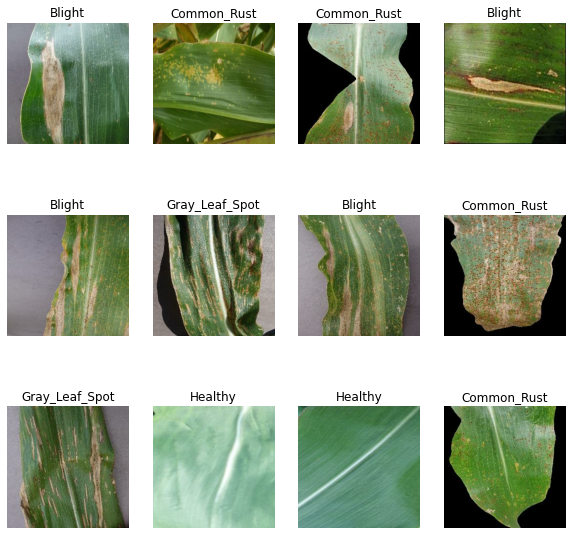

In [12]:
# https://www.tensorflow.org/tutorials/load_data/images
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
len(dataset)

131

In [14]:
train_size = 0.8
len(dataset)*train_size

104.80000000000001

In [15]:
train_ds = dataset.take(104)
len(train_ds)

104

In [16]:
test_ds = dataset.skip(104)
len(test_ds)

27

In [17]:
val_size = 0.1
len(dataset)*val_size

13.100000000000001

In [18]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [19]:
test_ds = test_ds.skip(13)
len(test_ds)

14

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=100):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))


104
13
14


In [22]:
# https://www.tensorflow.org/tutorials/load_data/images
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
# https://www.tensorflow.org/tutorials/load_data/images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.3)
])

In [24]:
# https://www.tensorflow.org/tutorials/load_data/images
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
classifier = Sequential()
#resize and augmentation
classifier.add(resize_and_rescale)
classifier.add(data_augmentation)

# Convolution Step 1
classifier.add(Conv2D(96, 11, strides=(4, 4), padding='valid',
               input_shape=input_shape, activation='relu'))
classifier.add(BatchNormalization())

# Max Pooling Step 1
classifier.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Convolution Step 2
classifier.add(Conv2D(96, 11, strides=(1, 1),
               padding='valid', activation='relu'))
classifier.add(BatchNormalization())

# Max Pooling Step 2
classifier.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Convolution Step 3
classifier.add(Conv2D(384, 3, strides=(1, 1),
               padding='valid', activation='relu'))
classifier.add(BatchNormalization())

# Convolution Step 4
classifier.add(Conv2D(384, 3, strides=(1, 1),
               padding='valid', activation='relu'))
classifier.add(BatchNormalization())

# Convolution Step 5
classifier.add(Conv2D(256, 3, strides=(1, 1),
               padding='valid', activation='relu'))

# Max Pooling Step 3
classifier.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Flattening Step
classifier.add(Flatten())

# Full Connection Step
classifier.add(Dense(units=4096, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(BatchNormalization())
classifier.add(Dense(units=4096, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(BatchNormalization())
classifier.add(Dense(units=n_class, activation='softmax'))

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
early_stopping = EarlyStopping(
    monitor='val_accuracy', min_delta=0.00005, patience=6, verbose=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1,
)
callbacks = [
    early_stopping,
    lr_scheduler
]
classifier.compile(optimizer=opt,
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [27]:
history = classifier.fit(train_ds, validation_data=val_ds,
                         batch_size=32, epochs=50, shuffle=True, callbacks=callbacks)

Epoch 1/50
104/104 [==============================] - 24s 118ms/step - loss: 1.2166 - accuracy: 0.5409 - val_loss: 1.7681 - val_accuracy: 0.2524 - lr: 1.0000e-05
Epoch 2/50
104/104 [==============================] - 4s 42ms/step - loss: 0.8019 - accuracy: 0.7043 - val_loss: 2.6608 - val_accuracy: 0.2524 - lr: 1.0000e-05
Epoch 3/50
104/104 [==============================] - 4s 42ms/step - loss: 0.6996 - accuracy: 0.7443 - val_loss: 2.8895 - val_accuracy: 0.2620 - lr: 1.0000e-05
Epoch 4/50
104/104 [==============================] - 4s 42ms/step - loss: 0.6349 - accuracy: 0.7641 - val_loss: 2.3087 - val_accuracy: 0.4351 - lr: 1.0000e-05
Epoch 5/50
104/104 [==============================] - 4s 42ms/step - loss: 0.6103 - accuracy: 0.7828 - val_loss: 1.5923 - val_accuracy: 0.5481 - lr: 1.0000e-05
Epoch 6/50
104/104 [==============================] - 4s 42ms/step - loss: 0.5987 - accuracy: 0.7903 - val_loss: 0.7497 - val_accuracy: 0.7308 - lr: 1.0000e-05
Epoch 7/50
104/104 [==================

In [30]:
scores = classifier.evaluate(test_ds)

14/14 [==============================] - 0s 23ms/step - loss: 0.4496 - accuracy: 0.8259


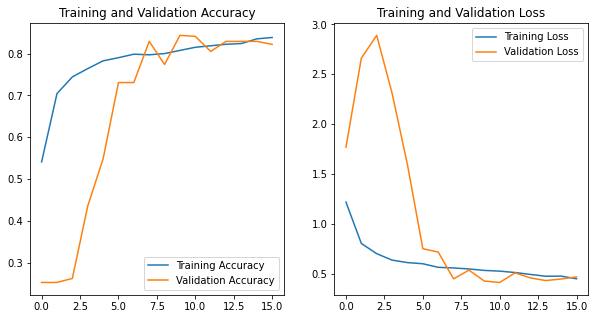

In [28]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


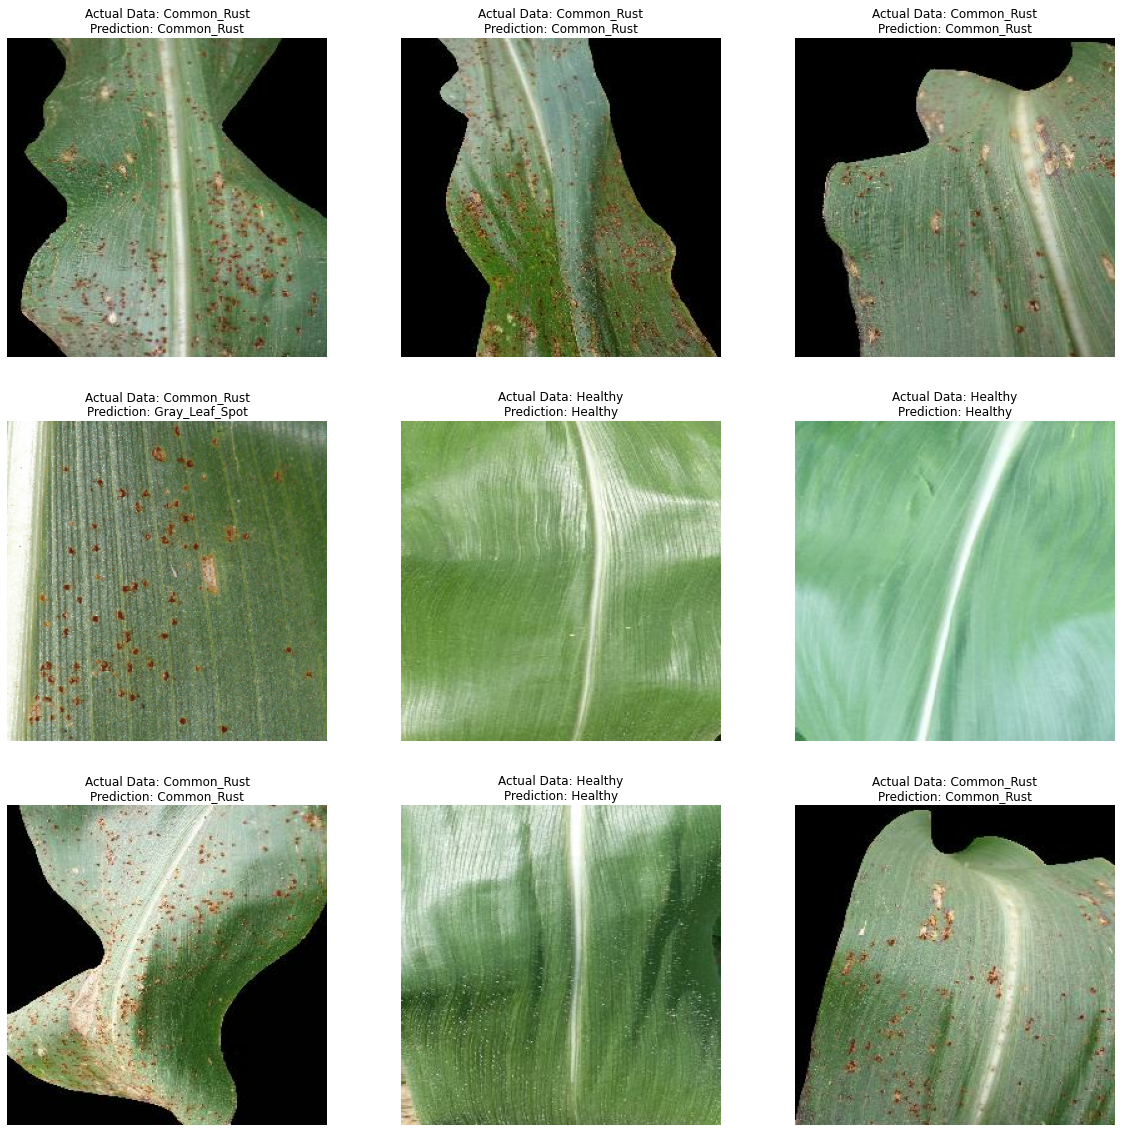

In [33]:
plt.figure(figsize=(20, 20))
for img, label in test_ds.take(1):
    for i in range(9):
        prediction = classifier.predict(img)
        ax = plt.subplot(3, 3, i+1)
        score = tf.nn.softmax(prediction[i])
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title('Actual Data: ' + class_names[label[i]] +
                  "\n" + 'Prediction: ' + class_names[np.argmax(score)])
        plt.axis('off'),
        plt.tight_layout